# Writing performant Julia code

## Introducing a toy example

In [1]:
function lap2d!(u, unew)
    M, N = size(u)
    for j in 2:N-1
        for i in 2:M-1
            unew[i,j] = 0.25 * (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1])
        end 
    end
end

lap2d! (generic function with 1 method)

In [2]:
function setup(N=4096, M=4096)
    u = zeros(M, N)
    # set boundary conditions
    u[1,:] = u[end,:] = u[:,1] = u[:,end] .= 10.0
    unew = copy(u);
    return u, unew
end

setup (generic function with 3 methods)

In [3]:
u, unew = setup()

([10.0 10.0 … 10.0 10.0; 10.0 0.0 … 0.0 10.0; … ; 10.0 0.0 … 0.0 10.0; 10.0 10.0 … 10.0 10.0], [10.0 10.0 … 10.0 10.0; 10.0 0.0 … 0.0 10.0; … ; 10.0 0.0 … 0.0 10.0; 10.0 10.0 … 10.0 10.0])

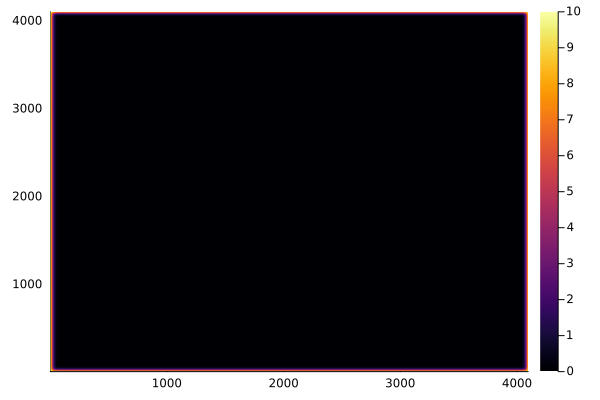

In [4]:
for i in 1:1000
    lap2d!(u, unew)
    # copy new computed field to old array
    u = copy(unew)
end

using Plots
heatmap(u)

## Benchmarking

In [5]:
using Pkg
Pkg.activate()
Pkg.add("BenchmarkTools")

  Activating project at `~/.julia/environments/v1.9`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [6]:
using BenchmarkTools
@benchmark lap2d!(u, unew)

BenchmarkTools.Trial: 306 samples with 1 evaluation.
 Range (min … max):  16.300 ms … 16.844 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     16.368 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.377 ms ± 54.332 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

          ▂▄▁█▂▅▃▃▅▂                                           
  ▂▁▂▄▅▅█▆███████████▇█▃▅▄▁▃▂▁▃▂▂▂▁▁▁▁▂▂▁▃▁▂▂▁▁▃▁▁▂▁▁▁▁▁▂▂▁▁▂ ▃
  16.3 ms         Histogram: frequency by time        16.6 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [7]:
bench_results = @benchmark lap2d!(u, unew)
typeof(bench_results)
println(minimum(bench_results.times))

1.6319666e7


## Profiling

In [8]:
Pkg.add("Profile")
using Profile

Profile.clear() # clear backtraces from earlier runs
@profile lap2d!(u, unew)
Profile.print()

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


Overhead ╎ [+additional indent] Count File:Line; Function
  ╎12 @Base/task.jl:514; (::IJulia.var"#15#18")()
  ╎ 12 @IJulia/src/eventloop.jl:8; eventloop(socket::ZMQ.Socket)
  ╎  12 @Base/essentials.jl:816; invokelatest
  ╎   12 @Base/essentials.jl:819; #invokelatest#2
  ╎    12 ...c/execute_request.jl:67; execute_request(socket::ZMQ.Soc...
  ╎     12 .../SoftGlobalScope.jl:65; softscope_include_string(m::Mod...
  ╎    ╎ 12 @Base/loading.jl:1903; include_string(mapexpr::typeo...
  ╎    ╎  12 @Base/boot.jl:370; eval
  ╎    ╎   12 In[1]:5; lap2d!(u::Matrix{Float64}, une...
10╎    ╎    10 @Base/array.jl:971; setindex!
 1╎    ╎    2  @Base/essentials.jl:14; getindex
Total snapshots: 26. Utilization: 100% across all threads and tasks. Use the `groupby` kwarg to break down by thread and/or task.


In [9]:
Pkg.add("ProfileView")
using ProfileView
@profview lap2d!(u, unew)

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


Gtk.GtkWindowLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1,000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, margin=0, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=FALSE, expand=FALSE, scale-factor=1, border-width=0, resize-mode, child, type=GTK_WINDOW_TOPLEVEL, title="Profile  -  16:48:07", role=NULL, resizable=TRUE, modal=FALSE, window-position=GTK_WIN_POS_NONE, default-width=800, default-height=600, destroy-with-parent=FALSE, hide-titlebar-when-maximized=FALSE, icon, icon-name=NULL, screen, type-hint=GDK_WINDOW_TYPE_HINT_NORMAL, skip

## Optimization options

In [10]:
function lap2d!(u, unew)
    M, N = size(u)
    for i in 2:M-1
        for j in 2:N-1
            unew[i,j] = 0.25 * (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1])
        end
    end
end

lap2d! (generic function with 1 method)

In [20]:
@benchmark lap2d!(u, unew)

BenchmarkTools.Trial: 33 samples with 1 evaluation.
 Range (min … max):  151.120 ms … 161.075 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     152.289 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   152.651 ms ±   1.636 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

        █▅                                                       
  ▄▁▄▅▄▄██▇▄▄▄▅▁▁▁▄▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  151 ms           Histogram: frequency by time          161 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [11]:
function lap2d!(u, unew)
    M, N = size(u)
    for j in 2:N-1
        for i in 2:M-1
            @inbounds unew[i,j] = 0.25 * (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1])
        end 
    end
end

lap2d! (generic function with 1 method)

In [12]:
@benchmark lap2d!(u, unew)

BenchmarkTools.Trial: 560 samples with 1 evaluation.
 Range (min … max):  8.861 ms …  9.571 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.924 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.935 ms ± 56.897 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

          ▅▇▄▅██▅▇▅▄▃▂                                        
  ▂▁▂▃▃▄▆▇█████████████▇▆▆█▆▃▃▄▄▃▄▃▃▃▃▃▁▂▁▃▁▁▃▁▃▂▂▁▃▂▂▂▂▃▁▁▂ ▄
  8.86 ms        Histogram: frequency by time         9.1 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [13]:
Pkg.add("StaticArrays")
using StaticArrays
m1 = rand(10,10)
m2 = @SArray rand(10,10)

@btime m1*m1
# 311.808 ns (1 allocation: 896 bytes)

@btime m2*m2
# 99.902 ns (1 allocation: 816 bytes)

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


  205.911 ns (1 allocation: 896 bytes)
  78.333 ns (1 allocation: 816 bytes)


10×10 SMatrix{10, 10, Float64, 100} with indices SOneTo(10)×SOneTo(10):
 4.23183  3.31469  3.39314  2.49356  …  3.02763  2.89907  2.62819  3.91745
 3.84689  3.22097  3.41675  2.50009     3.39353  2.9861   2.6123   4.20402
 3.84136  3.43131  3.93566  2.79477     2.97893  2.96797  2.69722  4.14073
 2.88821  2.4489   2.76144  2.07266     2.19169  2.21179  1.84408  2.82151
 3.87169  3.26941  3.52069  2.43965     2.59355  3.01141  2.27799  3.59348
 4.6407   3.48846  3.92158  3.3258   …  3.4062   3.40768  2.56756  4.44225
 3.42795  3.07016  3.215    2.36316     2.577    2.45683  2.41049  3.3692
 3.54633  2.92101  3.27868  2.37565     2.97597  2.88617  2.50048  3.85438
 2.91958  2.30316  2.41851  1.97028     2.35987  2.16525  2.44376  3.47282
 2.66549  2.07896  2.40805  1.84985     2.18504  1.95045  1.37529  2.53487